In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 92)
(631390, 1)
validation
(74368, 92)
(74368, 1)
test
(85358, 92)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 784385 (2.99 MB)


Trainable params: 784385 (2.99 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:27 - loss: 0.1183 - STD: 4.6677e-05 - MAE: 0.3320

 6/64 [=>............................] - ETA: 0s - loss: 0.0409 - STD: 7.3905e-05 - MAE: 0.1549  

11/64 [====>.........................] - ETA: 0s - loss: 0.0371 - STD: 5.9965e-05 - MAE: 0.1484

17/64 [======>.......................] - ETA: 0s - loss: 0.0296 - STD: 6.1390e-05 - MAE: 0.1239

23/64 [=========>....................] - ETA: 0s - loss: 0.0263 - STD: 6.9015e-05 - MAE: 0.1208

29/64 [============>.................] - ETA: 0s - loss: 0.0235 - STD: 7.7331e-05 - MAE: 0.1101

34/64 [==============>...............] - ETA: 0s - loss: 0.0221 - STD: 8.4008e-05 - MAE: 0.1028

39/64 [=================>............] - ETA: 0s - loss: 0.0209 - STD: 9.2824e-05 - MAE: 0.0983

42/64 [==================>...........] - ETA: 0s - loss: 0.0205 - STD: 9.8831e-05 - MAE: 0.0972

47/64 [=====================>........] - ETA: 0s - loss: 0.0198 - STD: 1.0951e-04 - MAE: 0.0953

53/64 [=======================>......] - ETA: 0s - loss: 0.0189 - STD: 1.2220e-04 - MAE: 0.0920

59/64 [==========================>...] - ETA: 0s - loss: 0.0183 - STD: 1.3673e-04 - MAE: 0.0894

64/64 [==============================] - ETA: 0s - loss: 0.0179 - STD: 1.5064e-04 - MAE: 0.0882

64/64 [==============================] - 3s 30ms/step - loss: 0.0179 - STD: 1.5064e-04 - MAE: 0.0882 - val_loss: 0.0167 - val_STD: 2.7856e-04 - val_MAE: 0.0830


Epoch 2/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0121 - STD: 3.3941e-04 - MAE: 0.0725

 6/64 [=>............................] - ETA: 0s - loss: 0.0127 - STD: 3.6513e-04 - MAE: 0.0712

11/64 [====>.........................] - ETA: 0s - loss: 0.0126 - STD: 3.8968e-04 - MAE: 0.0694

16/64 [======>.......................] - ETA: 0s - loss: 0.0126 - STD: 4.2102e-04 - MAE: 0.0694

21/64 [========>.....................] - ETA: 0s - loss: 0.0126 - STD: 4.5780e-04 - MAE: 0.0699

26/64 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 4.9847e-04 - MAE: 0.0699

31/64 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 5.4491e-04 - MAE: 0.0697

36/64 [===============>..............] - ETA: 0s - loss: 0.0126 - STD: 6.0041e-04 - MAE: 0.0697

42/64 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 6.8257e-04 - MAE: 0.0698

47/64 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 7.6500e-04 - MAE: 0.0698

52/64 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 8.6717e-04 - MAE: 0.0697

57/64 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 9.9663e-04 - MAE: 0.0697

62/64 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 0.0012 - MAE: 0.0696    

64/64 [==============================] - 1s 11ms/step - loss: 0.0125 - STD: 0.0012 - MAE: 0.0695 - val_loss: 0.0160 - val_STD: 0.0033 - val_MAE: 0.0770


Epoch 3/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0126 - STD: 0.0041 - MAE: 0.0694

 6/64 [=>............................] - ETA: 0s - loss: 0.0118 - STD: 0.0048 - MAE: 0.0672

12/64 [====>.........................] - ETA: 0s - loss: 0.0117 - STD: 0.0060 - MAE: 0.0669

18/64 [=======>......................] - ETA: 0s - loss: 0.0113 - STD: 0.0078 - MAE: 0.0661

23/64 [=========>....................] - ETA: 0s - loss: 0.0111 - STD: 0.0100 - MAE: 0.0651

28/64 [============>.................] - ETA: 0s - loss: 0.0106 - STD: 0.0129 - MAE: 0.0634

34/64 [==============>...............] - ETA: 0s - loss: 0.0100 - STD: 0.0180 - MAE: 0.0612

40/64 [=================>............] - ETA: 0s - loss: 0.0094 - STD: 0.0247 - MAE: 0.0585

45/64 [====================>.........] - ETA: 0s - loss: 0.0088 - STD: 0.0309 - MAE: 0.0565

50/64 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.0368 - MAE: 0.0546

55/64 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.0417 - MAE: 0.0530

61/64 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0467 - MAE: 0.0513

64/64 [==============================] - 1s 11ms/step - loss: 0.0072 - STD: 0.0490 - MAE: 0.0506 - val_loss: 0.0054 - val_STD: 0.0757 - val_MAE: 0.0416


Epoch 4/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0031 - STD: 0.0939 - MAE: 0.0346

 6/64 [=>............................] - ETA: 0s - loss: 0.0030 - STD: 0.0959 - MAE: 0.0346

11/64 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0961 - MAE: 0.0344

16/64 [======>.......................] - ETA: 0s - loss: 0.0029 - STD: 0.0965 - MAE: 0.0340

21/64 [========>.....................] - ETA: 0s - loss: 0.0028 - STD: 0.0969 - MAE: 0.0338

26/64 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.0973 - MAE: 0.0336

32/64 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.0978 - MAE: 0.0335

38/64 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0980 - MAE: 0.0334

43/64 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0984 - MAE: 0.0333

48/64 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0985 - MAE: 0.0332

53/64 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0987 - MAE: 0.0332

59/64 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0990 - MAE: 0.0331

64/64 [==============================] - 1s 11ms/step - loss: 0.0025 - STD: 0.0990 - MAE: 0.0331 - val_loss: 0.0032 - val_STD: 0.0844 - val_MAE: 0.0368


Epoch 5/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0330

 7/64 [==>...........................] - ETA: 0s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0325

13/64 [=====>........................] - ETA: 0s - loss: 0.0023 - STD: 0.1009 - MAE: 0.0324

19/64 [=======>......................] - ETA: 0s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0323

24/64 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0323

29/64 [============>.................] - ETA: 0s - loss: 0.0023 - STD: 0.1015 - MAE: 0.0322

34/64 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0322

40/64 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0321

46/64 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0321

51/64 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0320

57/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0320

63/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0320

64/64 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.1017 - MAE: 0.0320 - val_loss: 0.0029 - val_STD: 0.0866 - val_MAE: 0.0354


Epoch 6/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0311

 7/64 [==>...........................] - ETA: 0s - loss: 0.0021 - STD: 0.1022 - MAE: 0.0316

12/64 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0315

18/64 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0315

24/64 [==========>...................] - ETA: 0s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0315

29/64 [============>.................] - ETA: 0s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0315

34/64 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0315

40/64 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0314

45/64 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0314

51/64 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0314

56/64 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1023 - MAE: 0.0314

61/64 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0314

64/64 [==============================] - 1s 11ms/step - loss: 0.0021 - STD: 0.1024 - MAE: 0.0313 - val_loss: 0.0028 - val_STD: 0.0884 - val_MAE: 0.0356


Epoch 7/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0309

 7/64 [==>...........................] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0309

12/64 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0308

18/64 [=======>......................] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0308

24/64 [==========>...................] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0309

30/64 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0308

35/64 [===============>..............] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0308

40/64 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0308

45/64 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0309

50/64 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0309

56/64 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0309

62/64 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0308

64/64 [==============================] - 1s 11ms/step - loss: 0.0020 - STD: 0.1029 - MAE: 0.0308 - val_loss: 0.0023 - val_STD: 0.0870 - val_MAE: 0.0323


Epoch 8/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0309

 7/64 [==>...........................] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0305

12/64 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0306

17/64 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0306

22/64 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0306

28/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0305

34/64 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

40/64 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

45/64 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

51/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0304

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0304

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0304

64/64 [==============================] - 1s 11ms/step - loss: 0.0019 - STD: 0.1034 - MAE: 0.0304 - val_loss: 0.0022 - val_STD: 0.0877 - val_MAE: 0.0324


Epoch 9/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0300

 6/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0302

12/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0303

17/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0303

23/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0303

29/64 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0303

35/64 [===============>..............] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0302

40/64 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0302

45/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0302

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0302

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0301

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0301

64/64 [==============================] - 1s 11ms/step - loss: 0.0019 - STD: 0.1036 - MAE: 0.0301 - val_loss: 0.0021 - val_STD: 0.0876 - val_MAE: 0.0319


Epoch 10/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0297

 7/64 [==>...........................] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

12/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0301

17/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0301

22/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0300

27/64 [===========>..................] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

33/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

39/64 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

44/64 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0300

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0299

64/64 [==============================] - 1s 11ms/step - loss: 0.0019 - STD: 0.1039 - MAE: 0.0299 - val_loss: 0.0022 - val_STD: 0.0900 - val_MAE: 0.0321


Epoch 11/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.1077 - MAE: 0.0303

 6/64 [=>............................] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0299

11/64 [====>.........................] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0299

16/64 [======>.......................] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0298

22/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0298

28/64 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0298

34/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

40/64 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

45/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0298

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0298

64/64 [==============================] - 1s 11ms/step - loss: 0.0019 - STD: 0.1041 - MAE: 0.0298 - val_loss: 0.0020 - val_STD: 0.0881 - val_MAE: 0.0309


Epoch 12/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0301

 7/64 [==>...........................] - ETA: 0s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0297

13/64 [=====>........................] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0297

18/64 [=======>......................] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0297

23/64 [=========>....................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0298

29/64 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

34/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297

39/64 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0297

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0297

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0297

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0297

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0297

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1041 - MAE: 0.0297 - val_loss: 0.0020 - val_STD: 0.0891 - val_MAE: 0.0311


Epoch 13/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0297

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0295

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0296

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0296

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0297

28/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0296

33/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0296

39/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0296

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0296

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0296

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0296

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0296

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1042 - MAE: 0.0296 - val_loss: 0.0019 - val_STD: 0.0884 - val_MAE: 0.0302


Epoch 14/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0291

 7/64 [==>...........................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0295

12/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0296

17/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0297

23/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0297

29/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0296

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0296

39/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0296

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0296

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0296

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0296

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0296

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1043 - MAE: 0.0296 - val_loss: 0.0020 - val_STD: 0.0894 - val_MAE: 0.0305


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.1068 - MAE: 0.0298

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0295

12/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0294

18/64 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0295

24/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0295

30/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0295

35/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0295

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0295

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0295

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0295

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0295

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0295 - val_loss: 0.0021 - val_STD: 0.0903 - val_MAE: 0.0313


Epoch 16/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0294

 7/64 [==>...........................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0295

13/64 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0295

18/64 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0295

24/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0294

30/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0294

35/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0294

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0294

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0294

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1042 - MAE: 0.0294 - val_loss: 0.0019 - val_STD: 0.0886 - val_MAE: 0.0303


Epoch 17/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1023 - MAE: 0.0295

 7/64 [==>...........................] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0295

13/64 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0296

18/64 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0296

23/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0295

29/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0295

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0295

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0295

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0294

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294 - val_loss: 0.0019 - val_STD: 0.0877 - val_MAE: 0.0299


Epoch 18/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0294

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0294

17/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0294

23/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0294

28/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0293

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0293

39/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

50/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0293

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0293

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0293

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0293 - val_loss: 0.0020 - val_STD: 0.0909 - val_MAE: 0.0308


Epoch 19/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0291

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0291

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0291

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0291

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0291

28/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0292

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0292

40/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0292

46/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0292

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0292

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0292

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0292

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1043 - MAE: 0.0292 - val_loss: 0.0021 - val_STD: 0.0907 - val_MAE: 0.0313


Epoch 20/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0289

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0293

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0293

16/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0292

21/64 [========>.....................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0292

26/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0292

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0292

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0292

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0292

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0292

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0292

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0292

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0292

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0292 - val_loss: 0.0020 - val_STD: 0.0905 - val_MAE: 0.0311


Epoch 21/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0292

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0292

12/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0292

18/64 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0292

24/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0292

29/64 [============>.................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

34/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0292

39/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0291

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0291

51/64 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0291

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0291

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0291

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1046 - MAE: 0.0291 - val_loss: 0.0020 - val_STD: 0.0911 - val_MAE: 0.0306


Epoch 22/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0290

 7/64 [==>...........................] - ETA: 0s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0293

12/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0292

17/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0292

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0292

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0292

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0292

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0291

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0292

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0291

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0291

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0291

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0291 - val_loss: 0.0020 - val_STD: 0.0904 - val_MAE: 0.0308


Epoch 23/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0290

 7/64 [==>...........................] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

13/64 [=====>........................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0291

19/64 [=======>......................] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0290

25/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0290

31/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0291

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0291

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0290

48/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0290

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0291

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0291

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0291

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1045 - MAE: 0.0291 - val_loss: 0.0020 - val_STD: 0.0914 - val_MAE: 0.0309


Epoch 24/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0293

 6/64 [=>............................] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0291

11/64 [====>.........................] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

17/64 [======>.......................] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

22/64 [=========>....................] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0290

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0290

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0290

37/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0290

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0290

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0290

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0290

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0290

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0290

64/64 [==============================] - 1s 11ms/step - loss: 0.0018 - STD: 0.1045 - MAE: 0.0290 - val_loss: 0.0021 - val_STD: 0.0912 - val_MAE: 0.0311


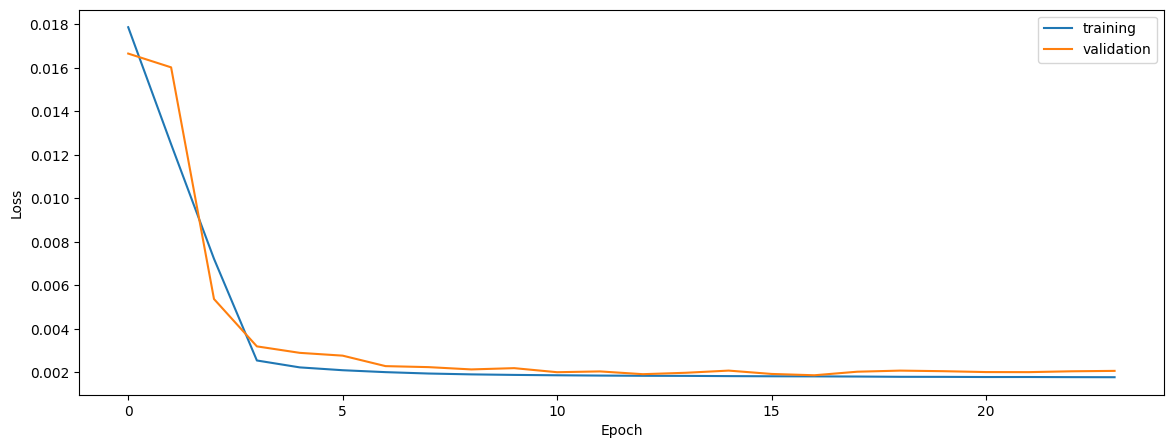

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9262709379347568
0.9434228228866196
0.9421970993422539


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9262709379347568
0.9434228228866196
0.9421970993422539


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9342672303913991
0.9466202368482739
0.9567624530456552


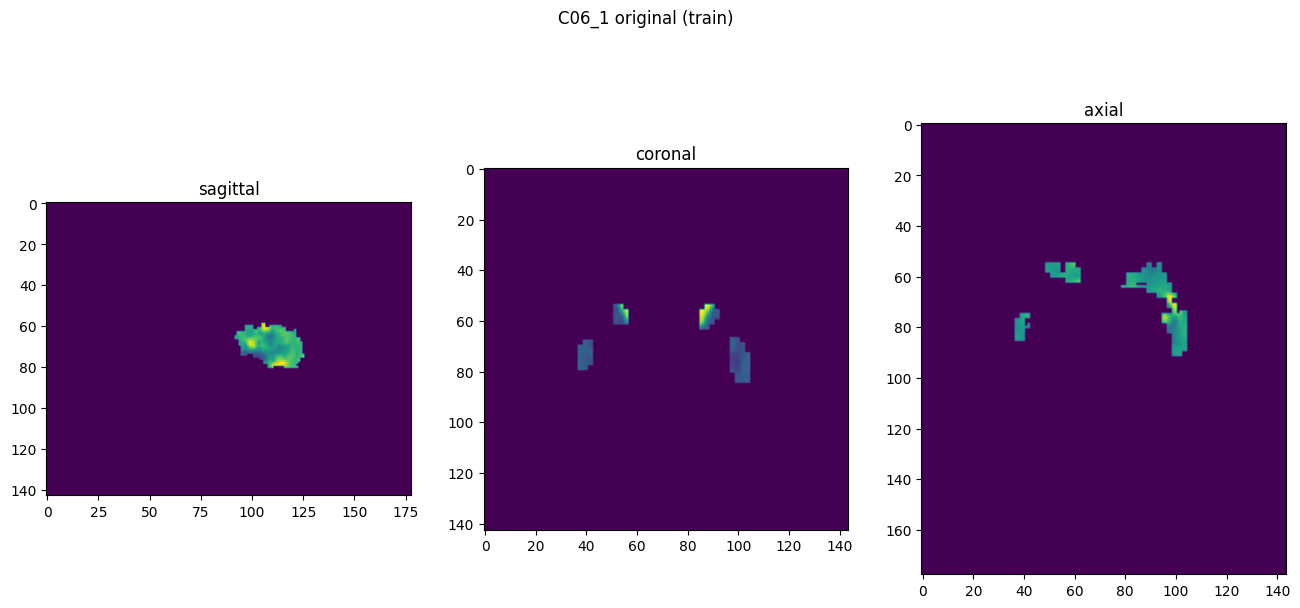

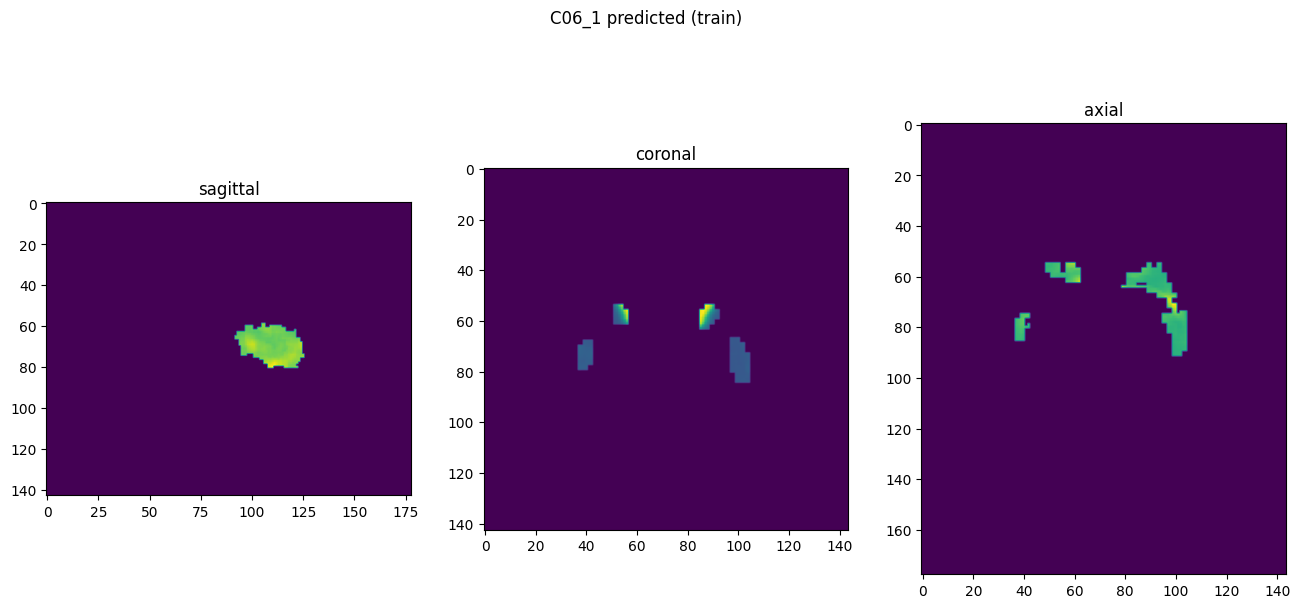

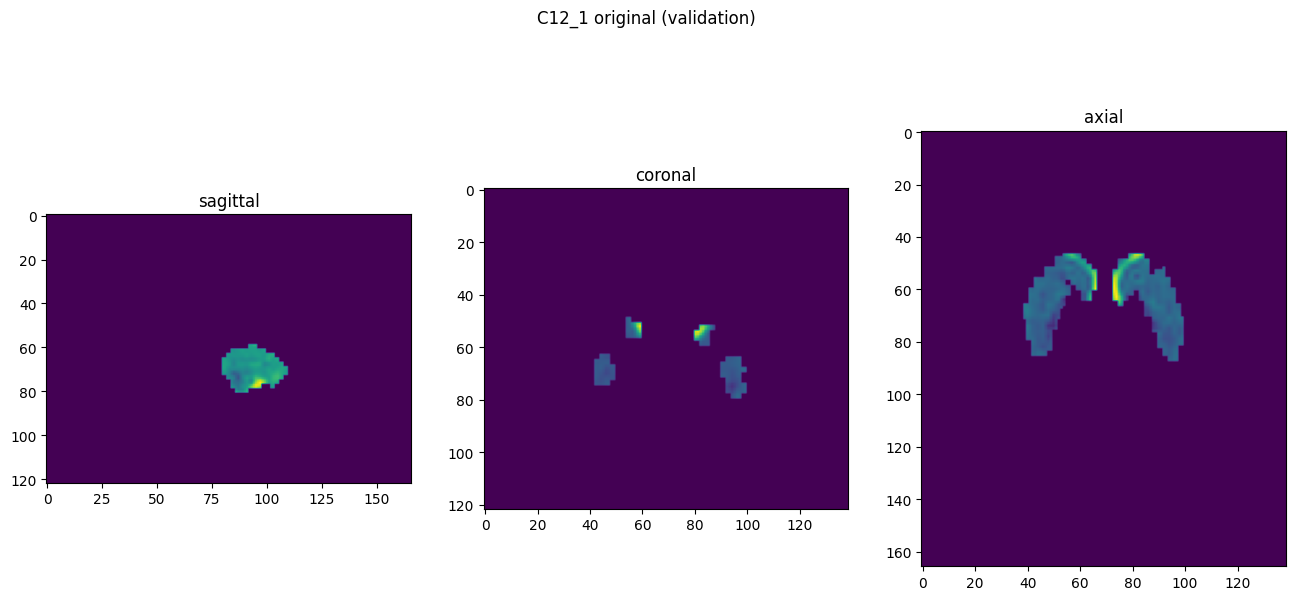

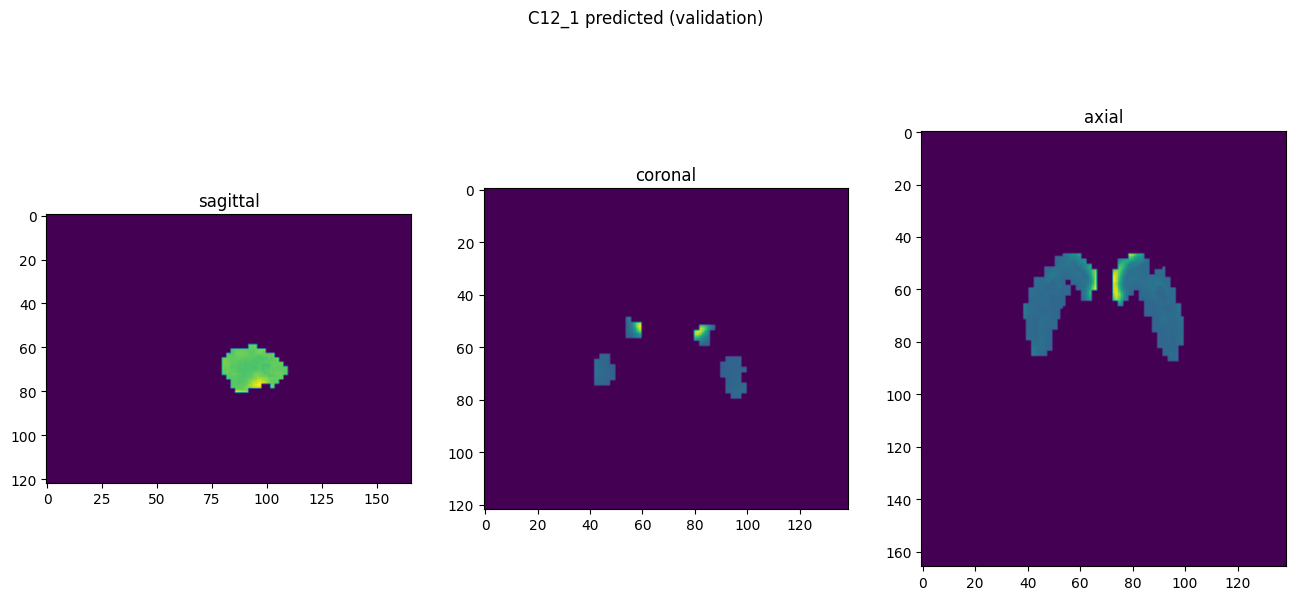

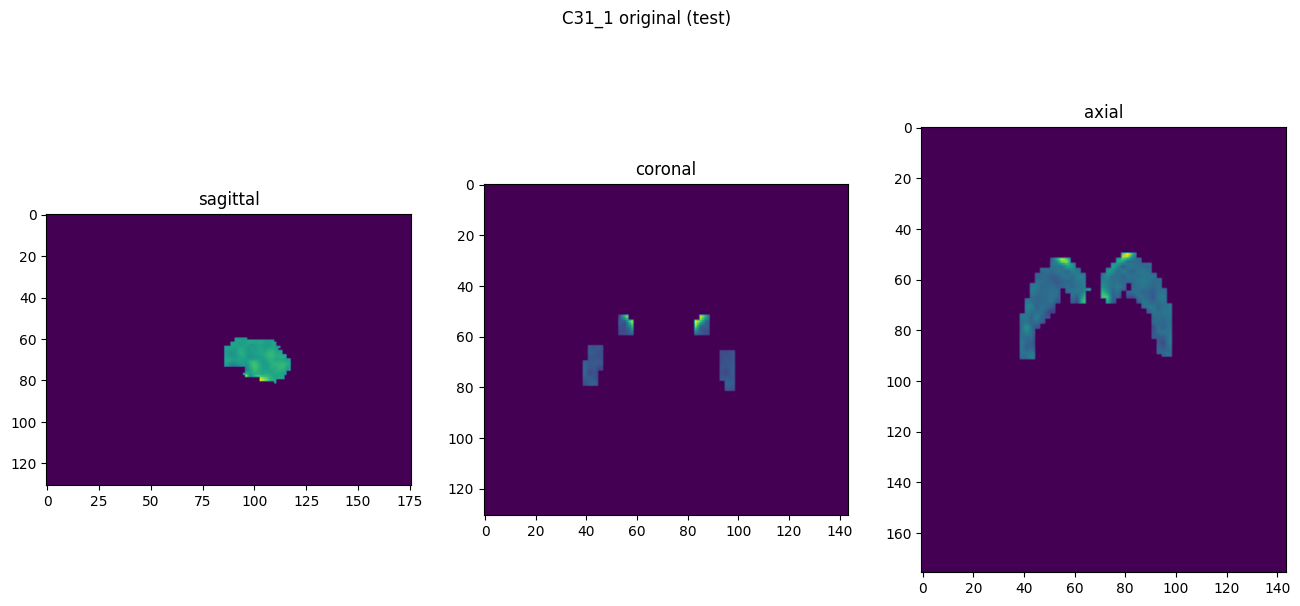

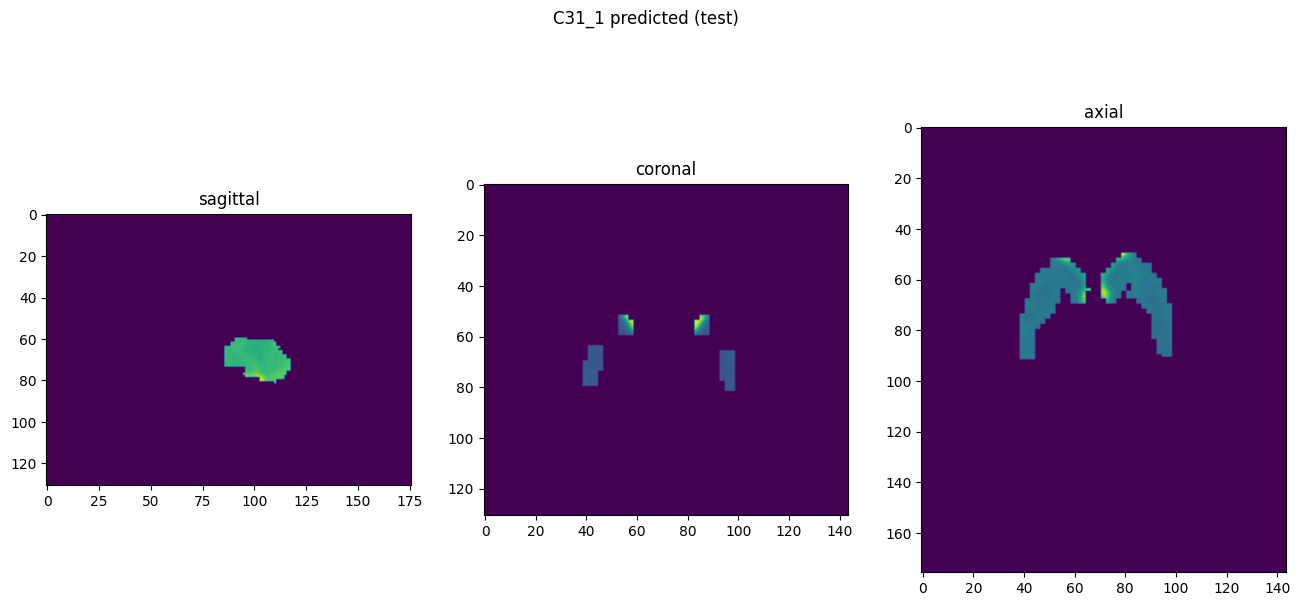

In [10]:
showResults(model, gen, threshold=None, background=False)